In [1]:
from ndslib.config import jupyter_startup
jupyter_startup()

(scikit-learn)=
# The Scikit-learn package

Now that we have a grasp on some of the key concepts, we can start *doing* machine learning in Python. In this section, we'll introduce *Scikit-learn* (often abbreviated `sklearn`), which is the primary package we'll be working with throughout this chapter. Scikit-learn is the most widely-used machine learning package in Python—and for that matter, probably in any programming language. Its popularity stems from its simple, elegant interface, [stellar documentation](https://scikit-learn.org/stable/documentation.html), and comprehensive support for many of the most widely used machine learning algorithms (the main domain Scikit-learn doesn't cover is deep learning, which we'll discuss separately in {numref}`dl`). Scikit-learn provides well-organized, high-quality tools for virtually all aspects of the typical machine learning workflow, including data loading and preprocessing, feature extraction and feature selection, dimensionality reduction, model selection, and evaluation, and so on. We'll touch on quite a few of these as we go along.

```{eval-rst}
.. index::
   single: Scikit Learn
```


## The ABIDE-II dataset

To illustrate how Scikit-learn works, we're going to need some data. Scikit-learn is built on top of Numpy, so in theory, we could use Numpy's random number generation routines to create suitable arrays for Scikit-learn, just as we did earlier. But that would be kind of boring. We already understand the basics of Numpy arrays at this point, so we can be a bit more ambitious here, and try to learn machine learning using a real neuroimaging dataset. For most of this chapter, we'll use a dataset drawn from the *Autism Brain Imaging Data Exchange II* (ABIDE II) project. ABIDE is an international consortium aimed at facilitating the study of autism spectrum disorder (ASD) by publicly releasing large-scale collections of structural neuroimaging data obtained from thousands of participants at dozens of research sites {cite}`di2017enhancing`. In this chapter, we'll use data from the second collection (hence the II in ABIDE II). To keep things simple, we're going to use a lightly preprocessed version of the ABIDE II dataset, provided in {cite}`bethlehem2020normative`.

```{eval-rst}
.. index::
   single: ABIDE-II
```

In [2]:
from ndslib.data import load_data
abide_data = load_data("abide2")

We can get a quick sense of the dataset's dimensions:

In [3]:
abide_data.shape

(1004, 1446)

And here are the first five rows:

In [4]:
display(abide_data.head(5))

site  subject        age  sex  group  age_resid  fsArea_L_V1_ROI  \
0   ABIDEII-KKI_1    29293   8.893151  2.0    1.0  13.642852           2750.0   
1  ABIDEII-OHSU_1    28997  12.000000  2.0    1.0  16.081732           2836.0   
2    ABIDEII-GU_1    28845   8.390000  1.0    2.0  12.866264           3394.0   
3   ABIDEII-NYU_1    29210   8.300000  1.0    1.0  13.698139           3382.0   
4   ABIDEII-EMC_1    29894   7.772758  2.0    2.0  14.772459           3080.0   

   fsArea_L_MST_ROI  fsArea_L_V6_ROI  fsArea_L_V2_ROI  ...  fsCT_R_p47r_ROI  \
0             306.0            354.0           2123.0  ...            3.362   
1             186.0            354.0           2261.0  ...            2.809   
2             223.0            373.0           2827.0  ...            2.435   
3             266.0            422.0           2686.0  ...            3.349   
4             161.0            346.0           2105.0  ...            2.428   

   fsCT_R_TGv_ROI  fsCT_R_MBelt_ROI  fsCT_R_LBelt_ROI  fsCT_R_A4_ROI  \
0           2.827             2.777             2.526          3.202   
1           3.539             2.944             2.769          3.530   
2           3.321             2.799             2.388          3.148   
3           3.344             2.694             3.030          3.258   
4           2.940             2.809             2.607          3.430   

   fsCT_R_STSva_ROI  fsCT_R_TE1m_ROI  fsCT_R_PI_ROI  fsCT_R_a32pr_ROI  \
0             3.024            3.354          2.629             2.699   
1             3.079            3.282          2.670             2.746   
2             3.125            3.116          2.891             2.940   
3             2.774            3.383          2.696             3.014   
4             2.752            2.645          3.111             3.219   

   fsCT_R_p24_ROI  
0           3.179  
1           3.324  
2           3.232  
3           3.264  
4           4.128  

[5 rows x 1446 columns]

We can see that each row contains data for a single participant and each column represents a different variable. The first 5 columns contain key identifiers and phenotypic variables: respectively, these include the research `site` the subject comes from (our dataset combines data from 17 different sites); the `subject`'s unique ID, and their `age` (in years), `sex`, and diagnosis `group` (where 1 indicates an autism diagnosis and 2 indicates a control subject). The sixth column is not in the original dataset and is a residualized version of the age variable that we'll talk more about later.

The remaining 1440 columns contain 4 sets of structural brain features extracted using the widely-used FreeSurfer package {cite}`fischl2012freesurfer`. Respectively, these include measures of surface area (`fsArea`), volume (`fsVol`), cortical thickness (`fsCT`), and local gyrification (`fsLGI`). Each set of FreeSurfer features contains 360 variables, reflecting the 360 regions of interest in the Human Connectome Project's multi-modal parcellation {cite}`glasser2016mmp1`, which looks roughly like this (each color is a different ROI):

![](./figures/hcp_mmp1.png)

### Data in Scikit-learn

Now that we have a suitable dataset, we need to get it to play well with Scikit-learn. It turns out we don't have to do much! As we mentioned earlier, Scikit-learn is built on top of Numpy and expects Numpy arrays as its inputs, but our `abide_data` variable is a pandas `DataFrame`. Fortunately, pandas `DataFrame` objects are built on top of the Numpy array object, so it turns out that passing our data to Scikit-learn is straightforward. The main thing we need to understand is how Scikit-learn expects its inputs to be structured, and verify that our dataset respects those expectations.

#### Feature data: the `X` matrix

The most important thing to know is that all model-fitting routines in Scikit-learn expect to receive a 2-dimensional Numpy array—conventionally named `X`—as their mandatory first input. `X` is expected to contain samples (i.e., independent observations) in rows and features in columns (this should remind you of the "tidy data" mentioned in {numref}`pandas`). For example, suppose we want to build a machine learning model that predicts a person's chronological age from their structural brain data. Then our `X` data will be expected to contain each participant's data on a separate row, and the columns of that row will be the values extracted for the brain features.

```{eval-rst}
.. index::
   single: Tidy Data
```

You'll probably notice that the expected structure of `X` is almost the same as the structure of our ABIDE-II dataset. There too, we had participants in rows and features in columns. How convenient! The only thing that might concern us is that our ABIDE-II dataset currently contains not only the brain features extracted with Freesurfer, but also a few identifier/phenotype columns that we probably wouldn't want to pass to Scikit-learn as part of the `X` matrix (e.g., because it wouldn't make sense to try to predict age from subject ID, and because `site` values are strings, whereas Scikit-learn expects `X` to contain only numbers). For the sake of clarity, then, let's break up our `abide_data` dataset into two separate data frames: one containing brain variables (we'll call it `features`), and one containing phenotypic information (`phenotypes`). This isn't strictly necessary, as we can always select only a subset of columns from `abide_data` to use as `X`, but it will help keep our code clearer and tidier below. The `DataFrame.filter` method allows us to select variables by name. In this case, we put all features that match "fs" -- which stands for Freesurfer -- in the `features` DataFrame:

In [5]:
features = abide_data.filter(like='fs')

```{eval-rst}
.. index::
   single: Freesurfer
```

And remember integer-based location indexing in pandas? Here we grab the first 6 columns:

In [6]:
phenotypes = abide_data.iloc[:, :6]

Let's verify that our `phenotypes` DataFrame now contains only the 5 phenotypic columns:

In [7]:
phenotypes.head(5)

site  subject        age  sex  group  age_resid
0   ABIDEII-KKI_1    29293   8.893151  2.0    1.0  13.642852
1  ABIDEII-OHSU_1    28997  12.000000  2.0    1.0  16.081732
2    ABIDEII-GU_1    28845   8.390000  1.0    2.0  12.866264
3   ABIDEII-NYU_1    29210   8.300000  1.0    1.0  13.698139
4   ABIDEII-EMC_1    29894   7.772758  2.0    2.0  14.772459

#### Labels: the `y` vector

For unsupervised learning applications in Scikit-learn, the feature data in `X` are all we need. But for supervised applications (i.e., classification and regression), where we're using `X` to try and recover some known ground truth, the features aren't enough; we also need labels—conventionally labeled `y`. Scikit-learn expects `y` to be a 1-dimensional array (or vector).

The variables we use as labels will vary across our examples, but let's start by assigning age to `y`. As mentioned above, Pandas objects are built on top of a Numpy array, and we can access this array by referring to the `values` attribute of the `Series` object:

In [8]:
y = phenotypes['age'].values

## Regression example: brain-age prediction

Now we're ready to train some machine learning models! Let's start with a regression example. We'll use Scikit-learn to try to predict the measured chronological age of subjects in our dataset from variations in their brain features. Predicting the biological age of a person from their neuroimaging data is a rather common use-case of machine learning. This is not just a neat party trick, though. There are reasons to think that a prediction of what is called "brain age" could also be scientifically useful. That's because certain conditions are associated with specific kinds of errors in brain age prediction. For further reading on this topic, refer to the papers mentioned below in {numref}`ml-sklearn-addtl-resources`.


```{eval-rst}
.. index::
   single: Brain age
```

### Estimators in Scikit-learn: Basic usage

One of Scikit-learn's most attractive features is its simple, unified interface for configuring estimators and fitting models. A good deal of the package consists of a very large set of `Estimator` classes you can use to do various forms of machine learning. In Scikit-learn, an `Estimator` does exactly what the word *estimator* normally means in statistics: it implements a rule for estimating some parameter(s) of interest from data. In much of this chapter, we'll use the terms *model* and *estimator* interchangeably, though it would be more technically accurate to say that an estimator relies internally on a particular model to generate its estimates.

While Scikit-learn includes dozens of different estimators that generate predictions in very different ways, they all share a common *application programming interface* (API)—meaning, the user interacts with them in a very similar way. In particular, every estimator class implements a `fit()` method. When we call an estimator's `fit()` method, we're telling the estimator to take some training data and do something with it. For supervised learning estimators, which we'll focus on first, we have to pass two arguments to `fit()`: an `X` matrix containing the feature data we want to use to generate predictions, and a `y` vector containing the true labels or scores. The goal of the training process is to try to recover the labels in `y` from the feature data in `X`.

```{eval-rst}
.. index::
   single: Application programming interface (API)
```

Once training is complete, we can call any supervised estimator's `predict()` method, which takes an `X` matrix as input and generates corresponding predictions for the `y` scores. The `X` matrix we provide to `predict()` can be the same as the one we used to `fit()` the estimator, though for reasons that will become clear later, doing that is often a spectacularly bad idea.

Conceptually, we can think of `fit()` and `predict()` as mapping onto distinct training and application phases: in the training phase, our model learns how to make predictions, and in the application phase, we deterministically use the information our model has learned to make predictions.

```{eval-rst}
.. index::
   single: Application Programming Interface
```


### Applying the `LinearRegression()` estimator

To see how this works in practice, let's try out one particular estimator in Scikit-learn: "ordinary" least-squares (OLS) regression. We'll start out small, using just a handful of brain features (rather than all 1,440) to generate a prediction. Let's sample, say, 5 features at random from the full set we've stored in `features`.

```{eval-rst}
.. index::
   single: Ordinary least-squares regression
```

We'll use the fact that Pandas `DataFrame` objects have a helpful sample method
for randomly sampling rows/columns. Passing a `random_state` argument allows us
to pass a fixed random seed, giving us deterministic results. This is very is
helpful when you're writing a book and prefer the reader's results not to change
every time they re-run your code.

In [9]:
n_features = 5

X = features.sample(n_features, axis=1, random_state=100)

Next, we import and initialize our linear regression estimator. Scikit-learn organizes estimators and other tools into modules based on what they're used for and/or the kind of model they represent. Linear models, including `LinearRegression`, are generally found in the `sklearn.linear_model` module.

In [10]:
from sklearn.linear_model import LinearRegression

An important principle of Scikit Learn is that the initialization of an estimator instance does not require any data to be passed. At initialization, only configuration parameters are passed. In particular, the `LinearRegression` estimator has relatively few configurable parameters, and for our purposes, the default settings are all fine (e.g., by default, `fit_intercept=True`, so Scikit-learn will automatically add an intercept column to our predictor matrix). This means that we initialize this object without any inputs:

In [11]:
model = LinearRegression()

#### Fitting the model

Now we're ready to fit our data! As noted above, we do this by calling the `.fit()` method. This is true for every `Estimator` in Scikit-learn.

In [12]:
model.fit(X, y)

LinearRegression()

Once we execute the above line, we have a fitted model. One thing we can do at
this point is to examine the estimated model parameters. The Scikit-learn
convention is to denote fitted parameters with a trailing underscore.

In [13]:
print("Estimated intercept:", model.intercept_)
print("Estimated coefficients:", model.coef_.round(2))

Estimated intercept: 53.813021917982496
Estimated coefficients: [-3.94  0.02 -8.92 -0.   -0.01]


The coefficients vary dramatically in size. This isn't because 2 of them are much more important than the other 3; it's because the 4 sets of FreeSurfer features are on very different scales (e.g., the surface area features have much larger values than the cortical thickness features). Later in the tutorial, we'll explicitly standardize the features so they're all on the same scale. But for now, it makes no difference, as the predictions we get out of a `LinearRegression` estimator are insensitive to scale.

#### Generating predictions

If we want to, we can use the parameter estimates extracted above to explicitly compute predictions for new observations. I.e., we would effectively be applying the following prediction equation (note that we're rounding to 2 digits for convenience; hence, the 4th variable drops out,  because its coefficient is very close to 0):

$\hat{y} = 53.81 - 3.94x_1 + 0.02x_2 - 8.92x_3 - 0.01x_5$

But we don't need to do this manually; we can easily generate predicted scores for new `X` data using the `.predict()` method that all supervised Scikit-learn estimators implement. For example, here are the predicted scores for our original `X` data:

In [14]:
y_pred = model.predict(X)

print(y_pred)

[15.69036168 11.17854891 16.67486452 ... 11.42650131 10.54443185
 14.57754089]


Let's visualize the predicted scores against the true scores. We'll make use of the `jointplot` plotting function in the Seaborn library we introduced in {numref}`viz`.

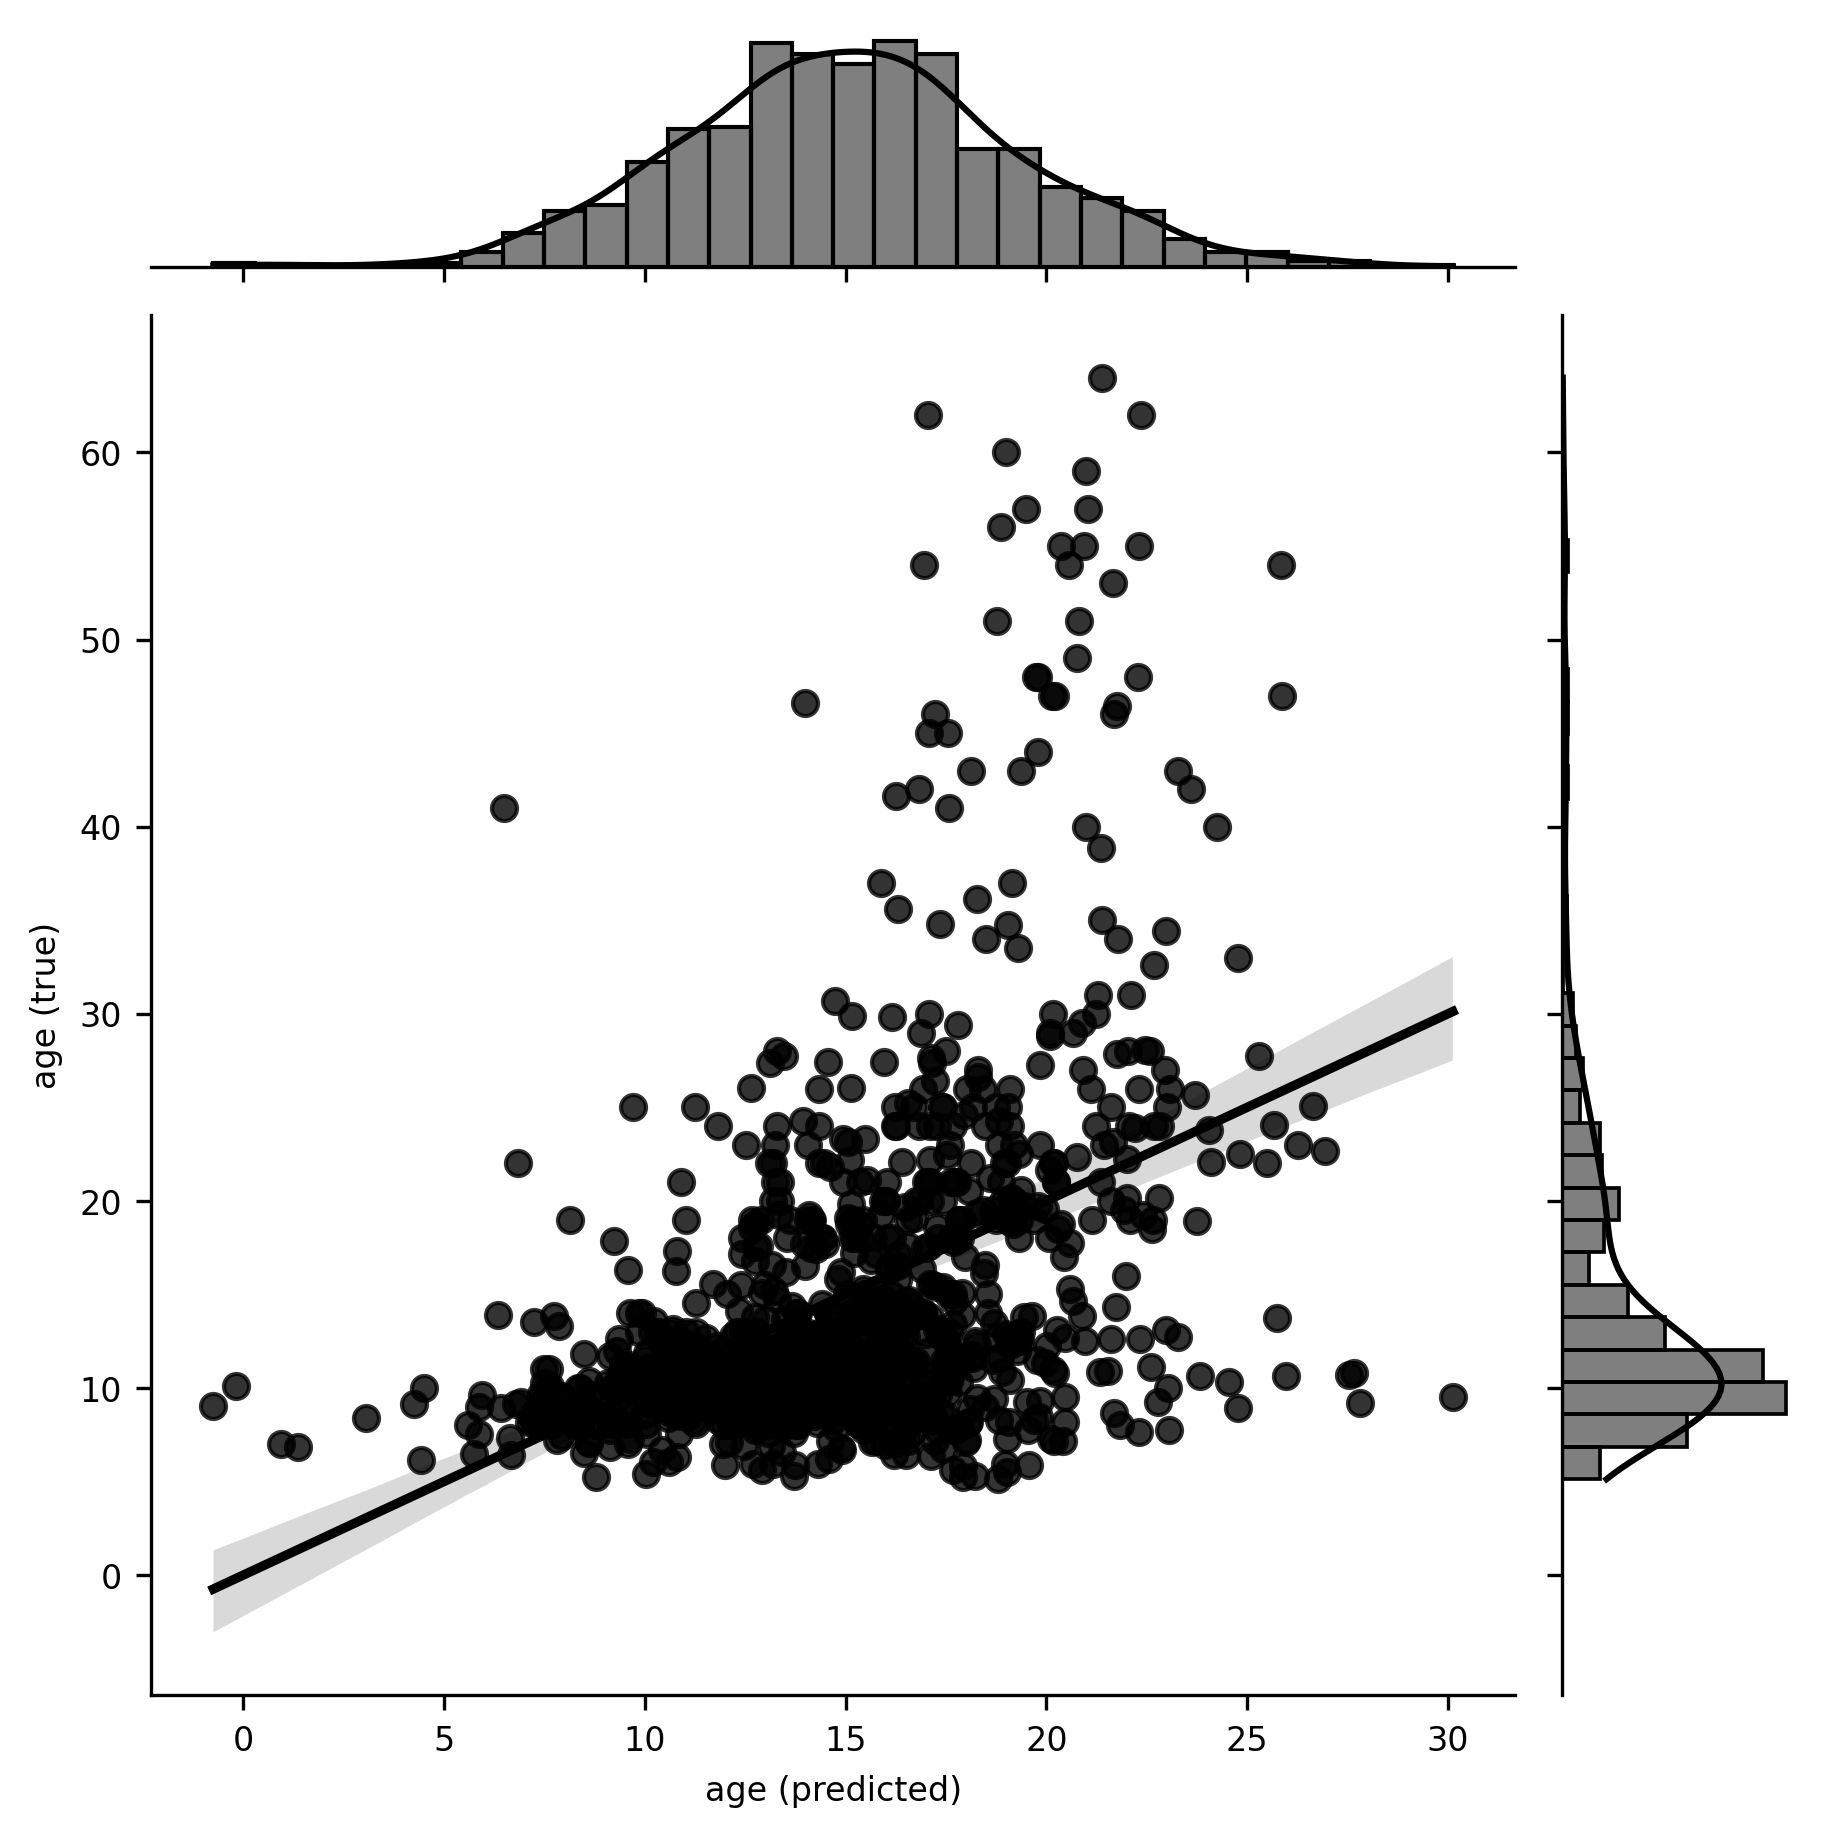

In [15]:
import seaborn as sns
g = sns.jointplot(x=y_pred, y=y, kind="reg").set_axis_labels("age (predicted)", "age (true)")

```{eval-rst}
.. index::
   single: Seaborn
```

Two things jump out at us from this plot. First, the model appears to be capturing some signal in the data, in that the predicted age values bear some non-trivial relationship to the true values. Second, the relationship appears to be non-linear, suggesting that our model might be misspecified. There are various ways we could potentially address this (as an exercise, try log-transforming age and repeating the estimation), but we won't worry about that here, as our goal is to learn machine learning in Scikit-learn, not to produce publishable results.

The key takeaway is that, in just a few lines of code, we've initialized a linear regression model, fitted it to some data, and generated new predicted scores. This basic pattern is common to all supervised estimators in Scikit-learn.

Just to underscore how little we had to do, here's the whole example again, in three lines, that:

1. Initialize the linear regression estimator.
2. Fit the model.
3. Generate predictions.

In [16]:
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

Once we've fit our model, we're going to want to see some results. At this point, if you're used to a point-and-click package like SPSS, or a statistics-oriented language like R, you might expect to see a big dump of information that includes things like regression coefficients, standard errors, p-values, $R^2$ values, and so on. Well... we're not going to talk about those things here. We *could* get that kind of information out of other Python packages (see {numref}`ml-sklearn-addtl-resources`). So, yes, we *could* do this kind of thing in Python. But it isn't really what machine learning (or Scikit-learn) is about. Instead, the focus in machine learning is on prediction. Typically, we have some quantitative metric of predictive performance we care about, and to the degree that a model can produce better values on that metric, we are inclined to evaluate the model more favorably. This doesn't mean that we have to single-mindedly base our evaluation of the model on *just* one quantity; in practice, many other considerations may come into play (e.g., computational efficiency, interpretability, etc.). The point is just that machine learning practitioners tend to care much more than traditional scientists do about what models can *do*, and are much less interested in drawing conclusions about the estimated values of the model's internal parameters. With that performance-oriented goal in mind, let's spend a bit of time thinking about how to measure the quality of a model's predictions.

### Quantifying performance in Scikit-learn: the metrics module

There are many metrics we could use to quantify the quality of the predictions our model generates. Scikit-learn conveniently packages some of the most commonly used performance metrics in its `metrics` module. As is true of `Estimator` objects, all metric functions in Scikit-learn have the same interface: we pass in the true scores and the model's predicted scores, respectively, and the function returns a number quantifying the relationship between the two.

#### The coefficient of determination ($R^2$)

```{eval-rst}
.. index::
   single: Coefficient of determination
```

Let's see how this works using one of the most commonly used metrics in regression problems: the coefficient of determination, or $R^2$, which quantifies the proportion of variance in the outcome variable (e.g., age) explained by the fitted model. We start by importing the `r2_score` function from the `sklearn.metrics` module. Then, we generate predicted values so we can compare them with the ground truth values. Generally, scoring functions are called by passing an array of true scores and an array of predicted scores as inputs, which is what we do here.

In [17]:
from sklearn.metrics import r2_score

y_pred = model.predict(X)
r2_score(y, y_pred)

0.2000318750191794

Our fitted linear regression model explains around 20% of the variance in age. Whether this is good or bad is a matter of perspective, but at the very least it's clear that we can non-trivially predict people's ages from a handful of structural brain features.

(scikit-learn_ex1)=
#### Exercises

1. Replace `r2_score` in the above code with `mean_squared_error`, `mean_absolute_error`, or one of the other predefined metrics in the `metrics` module.
2. Write your own metric function. To be a valid metric function it should take the true scores and predicted scores (in that order) as the only arguments and compute a single number.

#### Built-in scoring

For convenience, supervised Scikit-learn estimators have a `.score()` method we can use as an alternative to the above. Instead of generating predicted scores and then explicitly feeding them to a metric function like `r2_score`, we can call `.score()` directly on the estimator after the `fit()` step, and the prediction will be done implicitly. The only downside of this approach is that we lose the ability to specify which scoring metric to use; the choice is made for us. In the example below, we will initialize a linear regression, fit it with data and then, instead of generating predictions and comparing them to the data, we directly produce the score. The `LinearRegression` object uses $R^2$ for scoring.

In [18]:
est = LinearRegression()
est.fit(X, y)
print(est.score(X, y))

0.2000318750191794


## Classification example: autism classification

```{eval-rst}
.. index::
   single: Classification
```

Now let's look at classification. In this case, the target labels we're trying to predict are discrete. In general, one can always turn a regression problem into a classification problem by discretizing the data in some way. For example, we could binarize our continuous age variable around the median value, giving us two equal-sized YOUNG and OLD groups. You'll see this done a lot in the literature, but frankly, discretizing continuous data for classification purposes is almost always a really bad idea (if you're interested in learning more about that, refer to {cite}`MacCallum2002-du`), and we're mostly mentioning that it *can* be done to point out that it generally *shouldn't* be done.

Fortunately, no continuous variables were harmed in the making of this book. Instead of dichotomizing continuous labels, we'll use a different set of labels that are naturally discrete: diagnosis group. Recall that ABIDE II is a project primarily interested in understanding autism, and roughly half of the participants in the dataset are diagnosed with autism (one might reasonably argue that the pathologies *underlying* autism could be dimensional rather than discrete, but the diagnoses themselves are discrete). So let's see if we can predict autism diagnosis, rather than age, from structural brain features.

To get a very rough qualitative sense of how difficult a prediction problem this
is likely to be, we can do a couple of things. First, we can look at the
bivariate correlations between age and each feature in turn, sorting them by the
strength of association. The `.corrwith()` is a DataFrame method that allows us
to correlate each column with another column taken from a passed Series or
DataFrame.

In [19]:
corrs = features.corrwith(phenotypes['group'])
print(corrs.sort_values().round(2))

fsCT_L_OFC_ROI      -0.14
fsCT_L_10d_ROI      -0.12
fsCT_R_31pd_ROI     -0.10
fsVol_L_10d_ROI     -0.10
fsCT_L_10v_ROI      -0.09
                     ... 
fsVol_L_STSvp_ROI    0.15
fsArea_R_OFC_ROI     0.15
fsLGI_R_OFC_ROI      0.15
fsLGI_L_OFC_ROI      0.19
fsArea_L_OFC_ROI     0.19
Length: 1440, dtype: float64


We can immediately see that none of our 1,440 features are very strongly correlated with the diagnosis group (the largest correlations are around r = 0.19). This doesn't mean that all is lost, however; even if each feature is individually only slightly predictive of the diagnosis group individually, the full set of 1,440 features could still conceivably be very strongly predictive of the diagnosis group in the aggregate.

One way to get a cursory sense of whether *that* might be true (i.e., whether combining features is likely to help separate autistic participants from controls) is to visualize the diagnosis group as a function of a few brain features. We can't visualize very well in more than 3 dimensions, so let's pick the 3 most strongly correlated features and use those. To probe for the separability of classes based on combinations of these variables, we plot three scatter plots of the relationships between them.

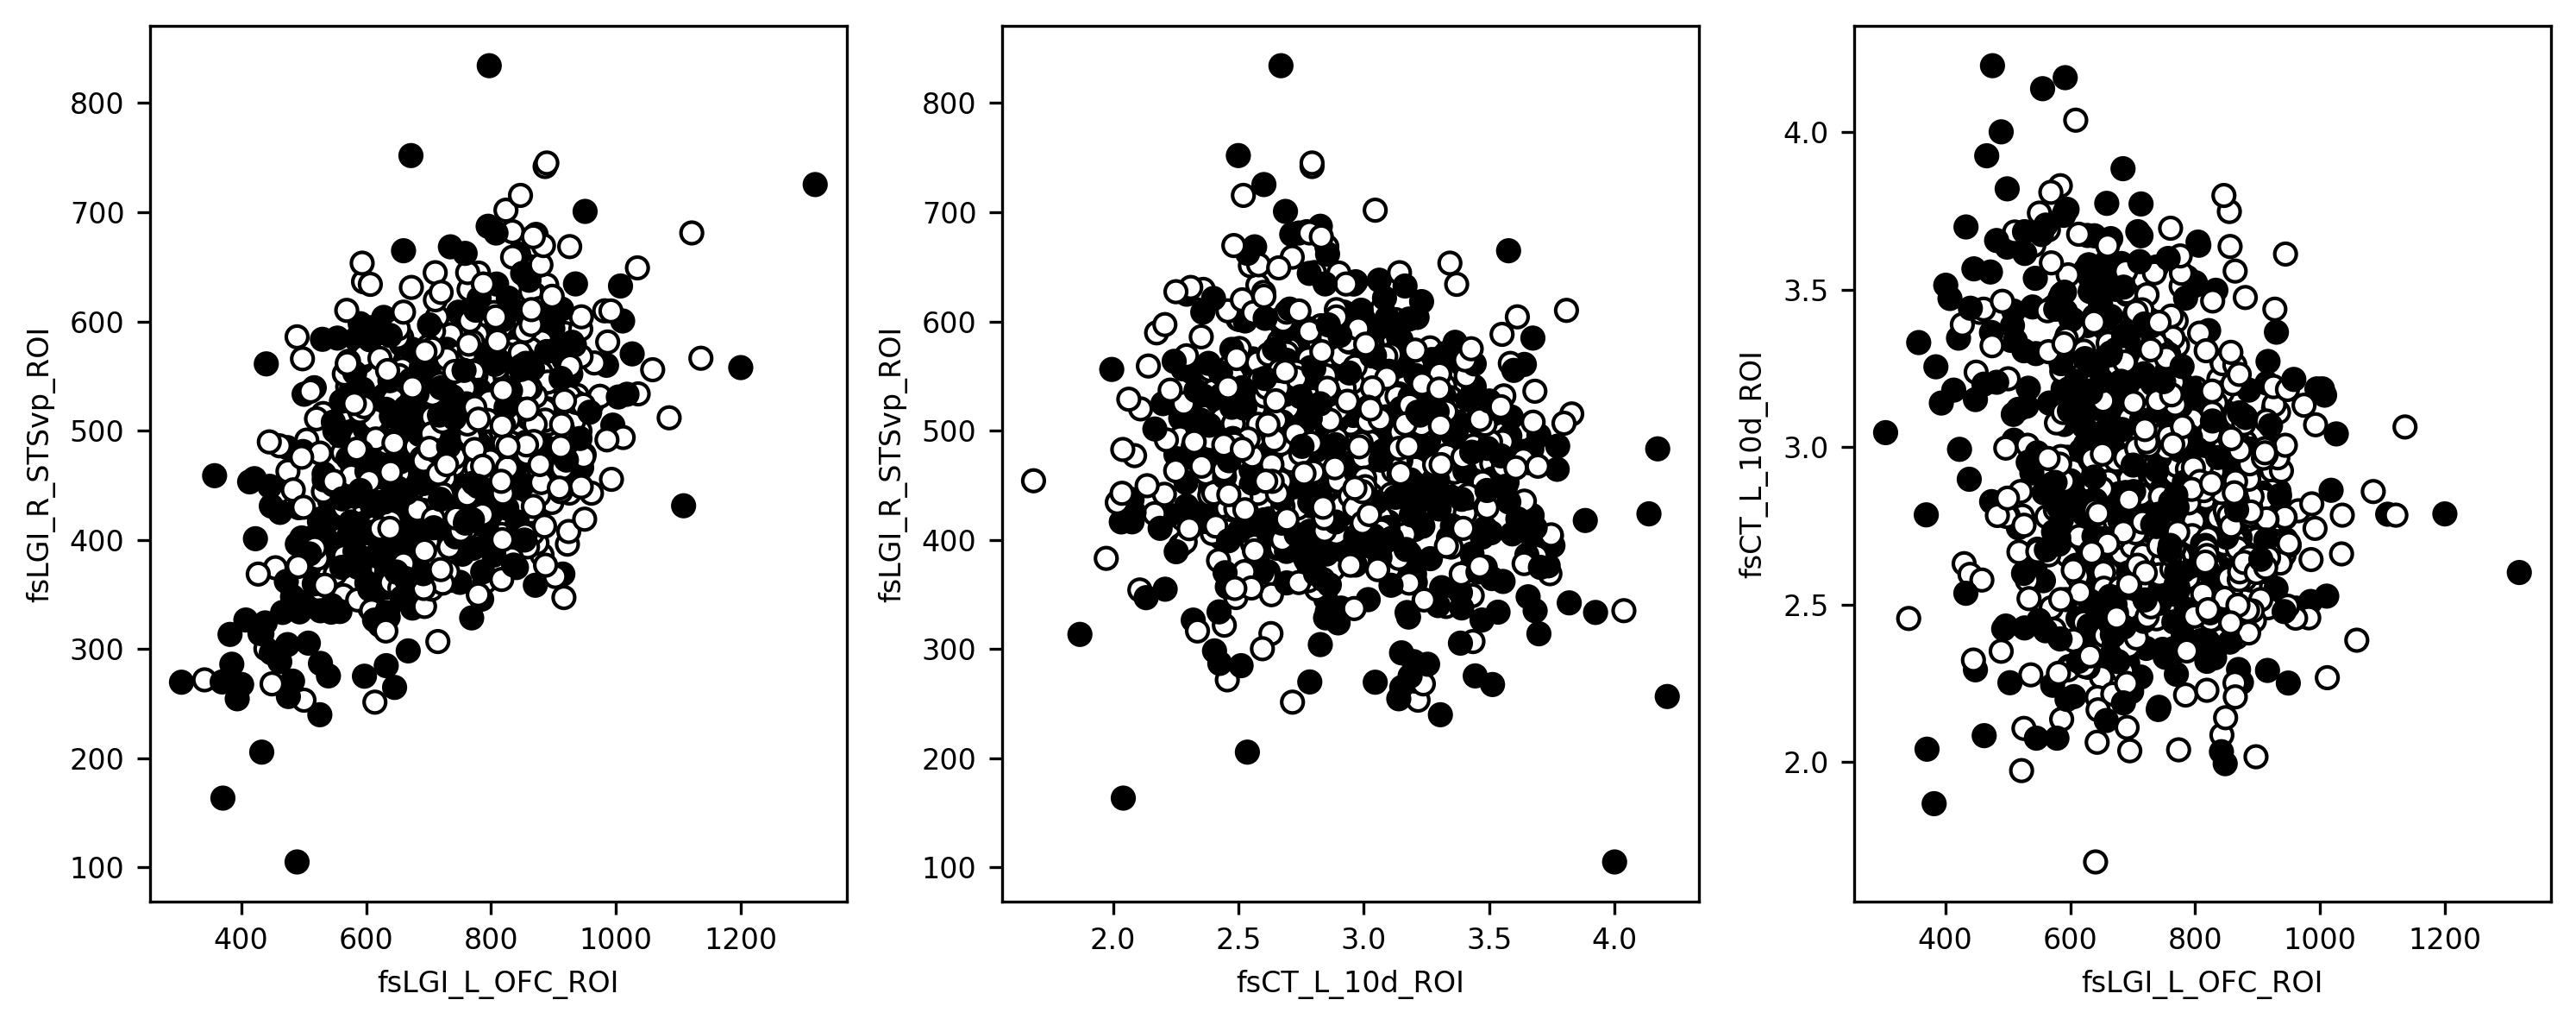

In [20]:
fs_vars = ['fsLGI_L_OFC_ROI', 'fsLGI_R_STSvp_ROI', 'fsCT_L_10d_ROI']
x, y, z = features[fs_vars].values.T

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 3)
ax[0].scatter(x, y, c=phenotypes['group'])
ax[0].set(xlabel=fs_vars[0], ylabel=fs_vars[1])
ax[1].scatter(z, y, c=phenotypes['group'])
ax[1].set(xlabel=fs_vars[2], ylabel=fs_vars[1])
ax[2].scatter(x, z, c=phenotypes['group'])
ax[2].set(xlabel=fs_vars[0], ylabel=fs_vars[2])
fig.set_tight_layout("tight")
fig.set_size_inches([10,4])

Remember in {numref}`class`, when we mentioned that in real-world classification problems, classes are often very hard to separate cleanly, and distributions tend to overlap heavily in feature space? Well, that's exactly what we're looking at here. The black and white dots are the two groups of participants, and it's pretty clear at a glance that there isn't going to be any hyperplane we could plunk down through that plot that would perfectly separate the two groups. Again though, we're still using only 3 of our features here, and there are 1,337 others. So let's see how we do when we scale things up to higher dimensions.

### Applying classifiers

Okay, onto the actual classification. How do we apply classification estimators in Scikit-learn? It's a trick question! We've already covered it in the regression example. There's essentially no difference in the way we interact with regression and classification estimators; we just have to be careful not to pass discrete labels to regression estimators, or continuous labels to classification estimators. But mechanically, we construct and fit the models in the same way.

```{eval-rst}
.. index::
   single: Gaussian Naive Bayes classifier
```

Let's try this out with a *gaussian Naive Bayes* (GNB) classifier. This is a
simple classification approach based on a "naive" application of Bayes' Theorem.
The naivete stems from the classifier's assumption that all features are
independent of one another once we condition on class assignment. This
assumption greatly simplifies analysis, though it's nearly always false. GNB is
a good classifier to use as a performance baseline, because it does surprisingly
well in many situations and is extremely computationally efficient, so it
should be quick. Naive Bayes classifiers have no trouble handling large sets of
highly correlated features and are also relatively resilient to overfitting
(we'll discuss overfitting in detail in {numref}`ml-overfitting`, so don't worry
if the term is new to you here). So we'll just throw everything we have at the
classifier, and try to predict the diagnosis class from all 1,440 features.

In [21]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y = phenotypes['group']
gnb = gnb.fit(features, y)

That's all there is to it! See how similar the code is to the regression example we did before?

### Evaluating classification performance

We already know how to obtain a performance estimate from the built-in scorer, so let's do that:

In [22]:
print(gnb.score(features, y))

0.6254980079681275


In this case, the default scoring metric is just overall accuracy (i.e., the proportion of all samples that were assigned to the correct class). We see that the model classifies about 63% of samples correctly.

Is 63% good or bad? As always, it depends. It's nowhere near good enough to be
useful in practical applications; on the other hand, it's better than randomly
guessing. Or is it? That would only be the case if there is an equal number of
participants that were diagnosed with autism as there are healthy controls. In
some datasets, there might be a *class imbalance*, in which case, randomly
guessing might do better than 50% (for example, by guessing that everyone
belongs to the more prevalent class). This is something that needs to be taken
into account when evaluating classification results. Fortunately, we can compute
some more nuanced scores.

#### Classification reports

The raw accuracy score is a good place to start when evaluating performance, but it often masks important nuances. We can get some more information using the `classification_report` utility, which breaks down classification performance into separate `precision`, `recall`, and `f1-score`  metrics (we could also get each of these individually from the `sklearn.metrics` module). Precision is also known as positive predictive value; it tells us the proportion of cases labeled as positive that truly are positive (e.g., the proportion of cases the classifier labels autistic that really are autistic). Recall (or sensitivity) tells us the proportion of true positive cases that were labeled as such by the classifier. The F1 score is the harmonic mean of recall and sensitivity and thus tries to summarize both using a single quantity.

The `classification_report` function reports these quantities both for the dataset as a whole, and broken down separately for each class:

In [23]:
from sklearn.metrics import classification_report
y_pred = gnb.predict(features)
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

         1.0       0.63      0.44      0.52       463
         2.0       0.62      0.78      0.69       541

    accuracy                           0.63      1004
   macro avg       0.63      0.61      0.61      1004
weighted avg       0.63      0.63      0.61      1004



Notice that while the precision, in this case, is almost identical for the two groups, the recall (or sensitivity) differs substantially: control subjects have a higher probability (78%) of being correctly labeled than subjects with an autism diagnosis (44%). This suggests a bias in the model—namely, that the model is more likely to assign cases to the control group than the autism group. We can verify this by looking at the overall proportion of cases our trained model labels as controls:

In [24]:
(y_pred == 2).mean()

0.6762948207171314

Sure enough, over two-thirds of cases are classified as controls, even though the ground truth is that only 54% of the sample is made up of controls.

Note that whether this bias in the trained model is a good or bad thing depends on one's context and goals. In the real world, there are often asymmetries in the costs associated with assigning different labels. For example, an HIV test should probably try very hard to minimize false negatives, because the cost of incorrectly telling someone they don't have HIV is likely to be higher than the cost of incorrectly telling them they *do* have HIV (seeing as follow-up tests will rapidly identify the latter error). On the other hand, if all we care about is maximizing overall classification accuracy for its own sake (e.g., as a learning exercise), then we might be perfectly happy to accept a model with these kinds of class-wise biases, providing their introduction helps us improve our overall performance. We'll spend much more time talking about tradeoffs and context-dependence in {numref}`ml-selection`, when we talk about the bias-variance tradeoff.

## Clustering example: are there neural subtypes of autism?

```{eval-rst}
.. index::
   single: Clustering
```

Recall that clustering is a form of unsupervised learning where we seek to assign our observations to discrete clusters in the absence of any knowledge of the ground truth (if there is one). Clustering applications are common in psychiatry and psychiatric imaging, as researchers often want to determine whether, e.g., patients with a particular diagnosis appear to cluster into somewhat distinct subtypes—with potential implications for prognosis, treatment, etc.

We can ask this question for the ABIDE data we have available. If we take only those subjects with an autism diagnosis, can we cluster subjects into discrete subtypes based on differences in the brain features we have available?

At this point, it probably won't surprise you to hear that Scikit-learn contains implementations of quite a few popular clustering algorithms. Clustering estimators in Scikit-learn are located, as you might intuit, in the `sklearn.cluster` module. We'll focus our attention on what is arguably the most widely used clustering algorithm, namely, *k*-means. In *k*-means clustering, we assign samples to *k* discrete clusters in such a way as to minimize the distance from each observation to the centroid of the cluster it belongs to, and maximize the distance between the cluster centroids. We won't get into the details of the k-means algorithm here; instead, we'll simply demonstrate how we'd go about running a cluster analysis with Scikit-learn. As you might expect by now, our code will look a lot like it did for regression and classification.


```{eval-rst}
.. index::
   single: K-means clustering
```

In principle, we could use all 1,440 features if we wanted to (though computation would likely be slow). But the unsupervised nature of clustering means that evaluating clustering solutions in high dimensions can be quite difficult. So let's focus on clustering observations in just 2 dimensions, and if after that you want to crank up the number of features.

In [25]:
n_features = 2

Next, we will use a few lines of code that will get our `X` data. We start by selecting subjects. We select only the subjects with an autism diagnosis and then randomly sample brain features.

In [26]:
aut_grp = phenotypes['group'] == 1
dx_1 = features[aut_grp].sample(n_features, axis=1)
columns = dx_1.columns

The `sklearn.preprocessing` module contains a bunch of useful utilities. In this case we're going to standardize our columns (i.e., to transform them so they have a mean of 0 and variance of 1). Otherwise, k-means will likely weigh some features more than others.

In [27]:
from sklearn.preprocessing import scale
dx_1 = scale(dx_1)

The actual clustering is, as usual, just a couple of lines of code. We'll use `KMeans` here, and we would encourage you to experiment with others, but note that many of the implemented clustering algorithms will be very slow if you crank up the number of features. Here, we have to stipulate the number of clusters (k) in advance and this is set even before fitting to the data. Instead of fitting and then predicting, we do both of these operations in one shot, using the `fit_predict` method of the `KMeans` class.

In [28]:
from sklearn.cluster import KMeans
K = 4
km = KMeans(K)
clusters = km.fit_predict(dx_1)

Notice that the only real difference between the above code and our earlier regression/classification examples is that we're no longer passing in a `y` array of labels—because there isn't one! We're just trying to find meaningful structure in the data, with no access to any ground truth.

Also notice that we need to specify the number of clusters *k* ourselves. There are literally hundreds of methods people have developed to try to identify the "optimal" value of *k*, and some of them are included in the `sklearn.metrics` module. But for our purposes, let's just focus on the solution we get for $k = 4$, for now.

Observe that the `clusters` array we get back by calling either `.predict()` or (as in this case) `fit_predict` on a clustering estimator gives us the assigned cluster labels for each observation. Since we only used two features to do our clustering, we can easily visualize the results of the clustering in a two-dimensional scatter plot, where each point is colored based on the cluster that was assigned to it (this is what the `c` keyword argument to scatter means):

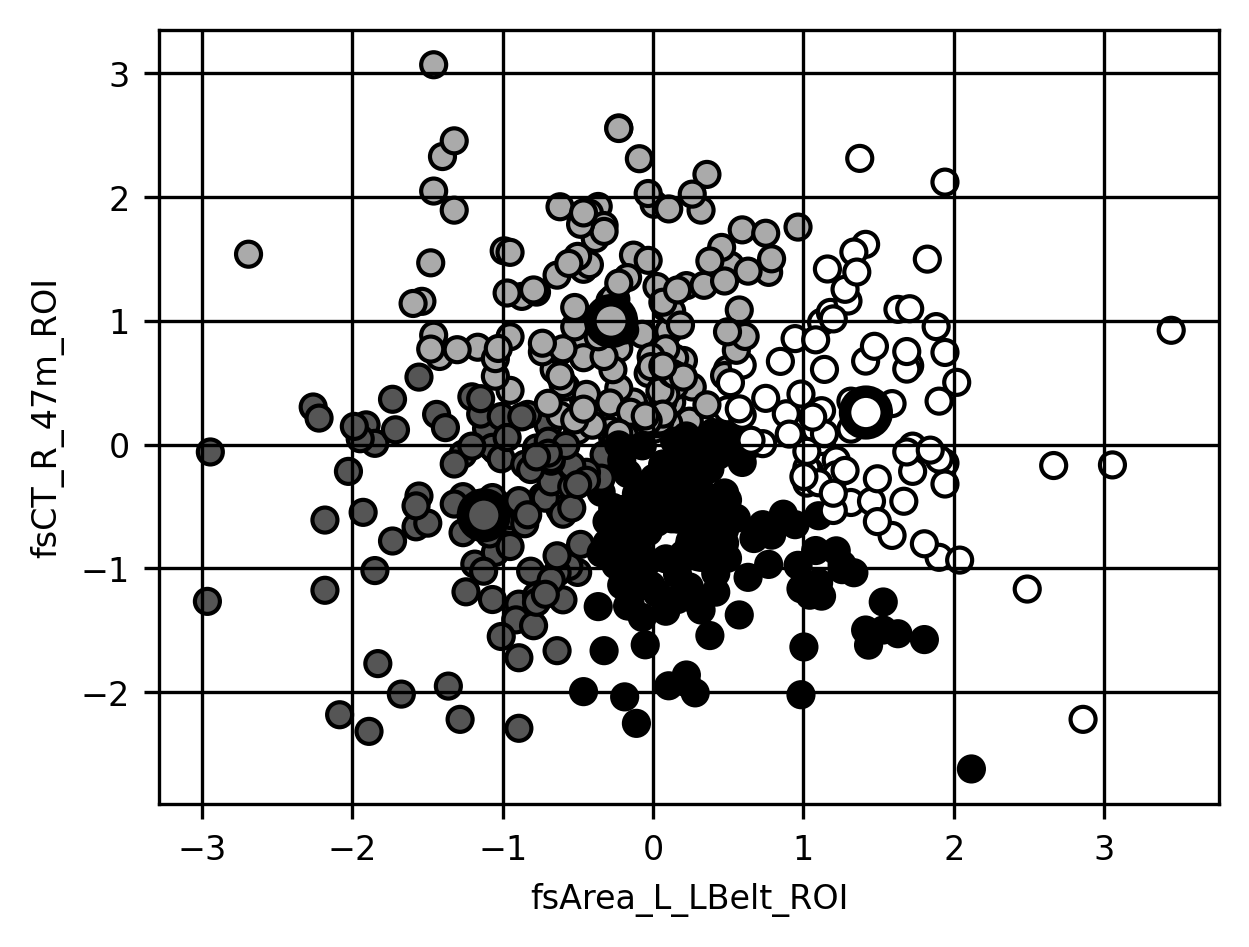

In [29]:
fig, ax = plt.subplots()
ax.scatter(dx_1[:, 0], dx_1[:, 1], c=clusters, edgecolor='k')
ax.scatter(*km.cluster_centers_.T, c=[0,1,2,3], edgecolor='k', linewidth=3, s=100)
ax.set_xlabel(columns[0])
ax.set_ylabel(columns[1])
g = ax.grid(None)

The clustering *looks* reasonable to the eye... but how far should we trust it? One way to assess clustering results is using *internal validation* methods. These methods look at the properties of the clusters and the data and quantify how well the clustering describes the observed data. For example, the Calinski-Harabasz score is quantified as the ratio between the sum of squared distances between clusters and the sum of squared distances within each of the clusters (does this remind you of something? This should remind you of the Otsu criterion used for image segmentation in {numref}`otsu`). The higher this number, the more well-separated the clusters.

```{eval-rst}
.. index::
   single: Internal validation
```

```{eval-rst}
.. index::
   single: Calinski-Harabasz score
```

In [30]:
from sklearn.metrics import calinski_harabasz_score
calinski_harabasz_score(dx_1, clusters)

272.2323352422725

An internal validation metric such as the Calinski-Harabasz score can be used to decide which $k$ to use, but does it really help us in understanding the clusters? Once we find an optimal $k$, which has the highest possible Calinski-Harabasz score, for example, how should we think about cluster labels? Are they merely convenient descriptions of the data that facilitate the exploration of differences between subgroups of participants, or do we think we're gaining deep insights into the "true" neural bases of different subtypes of autism? Another approach to validate the results of clustering is via *external validation*. In this approach, some other data is used to determine whether the results of clustering make sense. For example, if the clusters represent meaningful differences in brain structure, we might hypothesize that the clusters could also differ in some other measurement. For example, we might validate the clustering of brain properties by looking at behavioral differences between participants that end up in each of the different clusters. Ultimately, how to think about clustering results can be a thorny question and not one that we will fully answer here, but it's an important one to think about whenever one applies clustering methods to complex real-world data.

```{eval-rst}
.. index::
   single: Internal validation
```

(ml-sklearn-addtl-resources)=
### Additional resources

As we mentioned in the text, in machine learning, we are usually more interested in quantifying the predictive capacity of a particular model. However, we acknowledge that sometimes what you want to do is to fit and evaluate parametric models. This is possible to do in Python using a package called [StatsModels](https://www.statsmodels.org). Another package that elegantly implements many of the statistical methods that behavioral scientists traditionally use (e.g., Analysis of Variance, or ANOVA) is [Pingouin](https://pingouin-stats.org/).

```{eval-rst}
.. index::
   single: Statsmodels
```

```{eval-rst}
.. index::
   single: Pingouin
```

```{eval-rst}
.. index::
   single: Analysis of variance (ANOVA)
```

To learn more about some of the concepts that we introduced here (e.g., Gaussian Naive Bayes and K-means clustering), we would particularly recommend the introductory statistical learning text [An Introduction to Statistical Learning](https://www.statlearning.com/). The book is an excellent introduction and is much more comprehensive than we could be in this chapter. Among its many merits is also the fact that it is available to download for free from the book website.

Many software packages implement machine learning methods for the analysis of neuroimaging data. One that stands out as particularly compatible with the Scikit-learn philosophy and API is the [Nilearn](https://nilearn.github.io). One reason for this compatibility is that many of the contributors to the Nilearn software are also developers of Scikit-learn.

```{eval-rst}
.. index::
   single: Nilearn
```